## Hyperparameter tuning

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error
import joblib

In [6]:
# Import the best model - Random Forest
rf_model = joblib.load('/home/davidkibet/Desktop/Life Expectancy ML/models/rf_model.pkl')

# load training and test sets
X_train = joblib.load("/home/davidkibet/Desktop/Life Expectancy ML/models/train_test_sets/X_train.pkl")
X_test = joblib.load("/home/davidkibet/Desktop/Life Expectancy ML/models/train_test_sets/X_test.pkl")
y_train = joblib.load("/home/davidkibet/Desktop/Life Expectancy ML/models/train_test_sets/y_train.pkl")
y_test = joblib.load("/home/davidkibet/Desktop/Life Expectancy ML/models/train_test_sets/y_test.pkl")
 

In [9]:
rf = RandomForestRegressor(random_state=42)

In [7]:
param_dist = {
    "n_estimators": [50, 100, 200, 300, 500],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=20,  # Number of random combinations to try
    cv=5,  # 5-fold cross-validation
    scoring="neg_mean_squared_error",
    verbose=2,
    n_jobs=-1  # Use all CPU cores
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   5.7s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   5.9s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   6.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=  10.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=  10.9s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=  11.9s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   5.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 300,
                                                         500]},
                   scoring='neg_mean_squared_error', verbose=2)

In [11]:
best_rf = random_search.best_estimator_
print("Best Params:", random_search.best_params_)

Best Params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}


In [12]:
y_pred = best_rf.predict(X_test)

In [15]:
y_pred_test = best_rf.predict(X_test)
y_pred_train = best_rf.predict(X_train)

In [16]:
# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# R-squared (R²) score
r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2}')

Mean Squared Error: 2.696932969387755
R² Score: 0.9688798938638382


In [17]:
from sklearn.metrics import r2_score

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train R² Score: {r2_train:.4f}")
print(f"Test R² Score: {r2_test:.4f}")

Train R² Score: 0.9943
Test R² Score: 0.9689


In [18]:
from sklearn.metrics import mean_absolute_error

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

print(f"Train MAE: {mae_train:.4f}")
print(f"Test MAE: {mae_test:.4f}")

Train MAE: 0.4624
Test MAE: 1.1066


In [19]:
from sklearn.metrics import mean_squared_error

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"Train MSE: {mse_train:.4f}")
print(f"Test MSE: {mse_test:.4f}")

Train MSE: 0.5164
Test MSE: 2.6969


In [ ]:
from sklearn.dummy import DummyRegressor

baseline = DummyRegressor(strategy="mean")
baseline.fit(X_train, y_train)
y_baseline_pred = baseline.predict(X_test)
baseline_mae = mean_absolute_error(y_test, y_baseline_pred)
print(f"Baseline MAE: {baseline_mae}")

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances
importances = best_rf.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame(
    {"Feature": X_train.columns, "Importance": importances}
).sort_values(by="Importance", ascending=False)

# Display the top features
print(feature_importance_df)


                            Feature  Importance
17  Income composition of resources    0.192984
1                   Adult Mortality    0.187412
12                         HIV/AIDS    0.169765
18                        Schooling    0.101871
7                              BMI     0.069922
8                under-five deaths     0.049035
16               thinness 5-9 years    0.031464
9                             Polio    0.030491
15             thinness  1-19 years    0.025504
11                      Diphtheria     0.022157
13                              GDP    0.020652
2                     infant deaths    0.016720
3                           Alcohol    0.013900
20                Status_Developing    0.012378
4            percentage expenditure    0.011367
10                Total expenditure    0.010214
19                 Status_Developed    0.010133
0                              Year    0.007369
5                       Hepatitis B    0.007212
6                          Measles     0

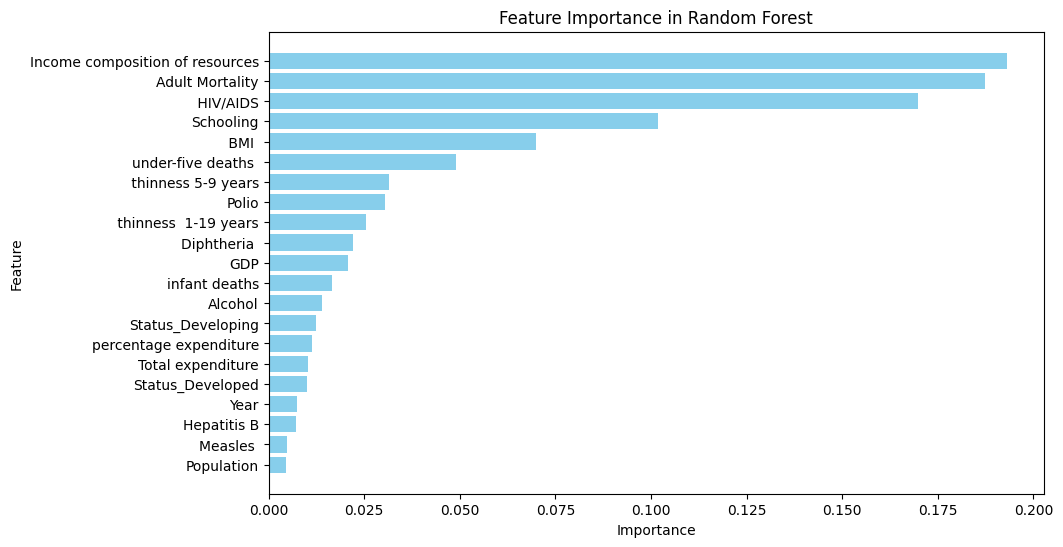

In [21]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()


### **1️⃣ Most Important Features**
1. **Income Composition of Resources (0.192984)**  
   - This is the most influential predictor.  
   - It likely represents a country's overall wealth, human development, and resource allocation.  
   - Higher values may correlate with longer life expectancy.

2. **Adult Mortality (0.187412)**  
   - Mortality rates significantly impact life expectancy.  
   - A high adult mortality rate suggests poor healthcare, shorter lifespans.

3. **HIV/AIDS (0.169765)**  
   - Strong negative impact on life expectancy in regions with high prevalence.  
   - Effective healthcare systems can mitigate this effect.

4. **Schooling (0.101871)**  
   - Education is tied to better health outcomes, economic opportunities, and awareness of diseases.  
   - Countries with higher schooling rates tend to have higher life expectancy.

---

### **2️⃣ Moderately Important Features**
5. **BMI (0.069922)**  
   - Can indicate nutritional status—both obesity and malnutrition affect longevity.  

6. **Under-Five Deaths (0.049035)**  
   - High child mortality rates reduce overall life expectancy.  
   - Likely linked to healthcare quality, nutrition, and sanitation.

7. **Thinness (5-9 years: 0.031464, 1-19 years: 0.025504)**  
   - Undernourishment in children can lead to long-term health issues.  

8. **Polio & Diphtheria (0.030491 & 0.022157)**  
   - Vaccination rates indicate the effectiveness of healthcare programs.  
   - Poor immunization coverage can increase disease burden and mortality.

---

### **3️⃣ Less Important Features**
9. **GDP (0.020652)**  
   - Wealthier nations generally have better healthcare, but GDP alone isn’t a perfect indicator.  

10. **Infant Deaths (0.016720)**  
    - Closely related to under-five mortality but slightly less significant in this model.  

11. **Alcohol Consumption (0.013900)**  
    - Excessive alcohol use can reduce life expectancy, but other factors (like healthcare) may buffer the effect.  

12. **Status (Developed: 0.010133, Developing: 0.012378)**  
    - Being a developed country slightly influences life expectancy but not as much as expected.  
    - Other variables (like GDP, schooling) already capture these differences.

13. **Year (0.007369)**  
    - Suggests that over time, there might be improvements in life expectancy, but it's not a major predictor.  

14. **Measles & Hepatitis B (0.004841 & 0.007212)**  
    - These individual diseases have a smaller effect on overall life expectancy compared to broader indicators like healthcare access.

15. **Population (0.004609)**  
    - Population size has almost no impact on life expectancy in this model.  

---

### **Key Takeaways**
✅ **Healthcare & Education Matter Most:** **Income composition, adult mortality, HIV/AIDS, and schooling** are the strongest predictors. Improving these can **significantly** increase life expectancy.  

✅ **Vaccination & Nutrition Play a Role:** **BMI, under-five deaths, polio, diphtheria, and thinness levels** indicate how well a country handles **child health and disease prevention**.  

✅ **Economic Indicators Have Mixed Influence:** **GDP and status (Developed vs. Developing)** are **less influential** than expected, suggesting that wealth alone doesn’t determine life expectancy—healthcare policies do.  

---

#### **What’s Next?**
📌 **Explore Feature Interactions:**  
- Does **education** moderate the effect of **income** on life expectancy?  
- How does **HIV/AIDS impact vary across GDP levels?**  

📌 **Try Removing Low-Impact Features:**  
- Features like **Measles, Hepatitis B, and Population** have minimal importance. Removing them might **simplify the model** without sacrificing accuracy.  

Would you like to test feature selection or another model tuning strategy? 🚀